In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

from scipy.stats import norm
from scipy.stats import stats
import pylab

from statsmodels.stats import diagnostic as dia

In [3]:
#all data has been processed
xy = pd.read_csv('loghousecount3.csv')
xy.head()

,AccommodationEatingandDrinking,Attractions,CommercialServices,EducationandHealth,ManufacturingandProduction,PublicInfrastructure,Retail,SportandEntertainment,Transport,simpson,AccommodationType,AgeStructure,EthniGroup,HouseholdComposition,Socioeconomic,Tenure,loghousecount,between2km,close2km
0,27,26,125,14,8,23,5,10,11,3.4321,1.4200,71.9200,7.6100,37.0200,28.1500,27.4100,0.5346,4.6893,2.6054
1,41,32,210,16,19,29,12,10,12,2.9837,1.7400,72.6800,5.8000,38.2000,28.9200,29.3200,0.6830,4.1110,2.5145
2,4,4,18,3,3,5,5,4,1,5.0091,0.4300,82.4600,10.2300,33.5600,47.4200,40.9500,0.3888,4.1744,2.5758
3,96,6,267,16,16,30,28,14,23,2.9476,1.9200,76.8700,25.5900,46.6800,86.1500,29.7100,1.1758,4.4815,2.5174
4,0,0,6,2,1,7,0,0,0,2.8444,24.7000,76.5900,39.9500,56.9600,90.3100,25.6500,0.7423,3.5562,2.1194


In [4]:
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [5]:
xy_vif= drop_column_using_vif_(xy.drop('loghousecount', axis=1))
print("The columns remaining after VIF selection are:")
print(xy_vif.columns)

Dropping: AccommodationEatingandDrinking
Dropping: PublicInfrastructure
The columns remaining after VIF selection are:
Index(['Attractions', 'CommercialServices', 'EducationandHealth',
       'ManufacturingandProduction', 'Retail', 'SportandEntertainment',
       'Transport', 'simpson', 'AccommodationType', 'AgeStructure',
       'EthniGroup', 'HouseholdComposition', 'Socioeconomic', 'Tenure',
       'between2km', 'close2km'],
      dtype='object')


In [6]:
#run OLS model
ols_xy_vif = sm.OLS(endog=xy[['loghousecount']], exog=sm.add_constant(xy_vif)).fit()
ols_xy_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          loghousecount   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     143.6
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        13:58:52   Log-Likelihood:                -2019.0
No. Observations:                4835   AIC:                             4072.
Df Residuals:                    4818   BIC:                             4182.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2230      0.089      2.511      0.012       0.049       0.397
Attractions                   -0.0004      0.001     -0.350      0.726      -0.003       0.002
CommercialServices            -0.0007      0.000     -4.240      0.000      -0.001      -0.000
EducationandHealth             0.0072      0.001      8.016      0.000       0.005       0.009
ManufacturingandProduction     0.0015      0.001      2.377      0.017       0.000       0.003
Retail                         0.0031      0.000      8.439      0.000       0.002       0.004
SportandEntertainment          0.0074      0.002      3.392      0.001       0.003       0.012
Transport                      0.0035      0.001      3.302      0.001       0.001       0.006
simpson                        0.0024      0.006      0.386      0.700      -0.010       0.015
AccommodationType              0.0115      0.000     24.039      0.000       0.011       0.012
AgeStructure                  -0.0005      0.001     -0.694      0.487      -0.002       0.001
EthniGroup                     0.0026      0.001      4.828      0.000       0.002       0.004
HouseholdComposition          -0.0005      0.001     -0.614      0.539      -0.002       0.001
Socioeconomic                 -0.0058      0.001    -11.511      0.000      -0.007      -0.005
Tenure                         0.0023      0.001      3.280      0.001       0.001       0.004
between2km                     0.0997      0.027      3.626      0.000       0.046       0.154
close2km                       0.1410      0.054      2.617      0.009       0.035       0.247
==============================================================================
Omnibus:                      105.701   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.348
Skew:                          -0.342   Prob(JB):                     8.97e-26
Kurtosis:                       3.325   Cond. No.                     2.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

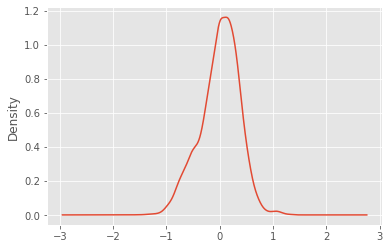

In [57]:
#veiw residuals
plt.figure()
ols_xy_vif.resid.plot.density()
plt.show()